# 1. Download and Imports

In [2]:
# Fundamental classes
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model

# Time
import time
import datetime

# Voice 
import pyttsx3

# Warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Functions

In [3]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [4]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

# 3. Loading Dataset (Traffic Signs Images)

In [6]:
# Setting variables for later use
data = []
labels = []
classes = 70
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join('./input/gtsrb-german-traffic-sign/','Train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

# 4. Data Splitting and conversion

In [7]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 70)
y_test = to_categorical(y_test, 70)

(42085, 30, 30, 3) (42085,)
(33668, 30, 30, 3) (8417, 30, 30, 3) (33668,) (8417,)


# 5. Creating and Compiling the Model

In [14]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(70, activation='softmax'))

# Compilation of the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Model display
model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 70)             │        35,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,638,790 (6.25 MB)

 Trainable params: 1,638,790 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training the Model

In [16]:
# Training the Model (with GPU if available)
with tf.device('/GPU:0'):
    epochs = 30
    history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.9885 - loss: 0.0547 - precision: 0.9894 - recall: 0.9878 - val_accuracy: 0.9920 - val_loss: 0.0421 - val_precision: 0.9926 - val_recall: 0.9916
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.9867 - loss: 0.0712 - precision: 0.9880 - recall: 0.9861 - val_accuracy: 0.9917 - val_loss: 0.0581 - val_precision: 0.9936 - val_recall: 0.9904
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.9911 - loss: 0.0403 - precision: 0.9917 - recall: 0.9898 - val_accuracy: 0.9935 - val_loss: 0.0476 - val_precision: 0.9946 - val_recall: 0.9926
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.9906 - loss: 0.0428 - precision: 0.9915 - recall: 0.9899 - val_accuracy: 0.9943 - val_loss: 0.0417 - val_precision: 0.9950 - val_recall: 0.9939
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.9912 - loss: 0.0445 - precision: 0.9918 - recall: 0.9907 - val_accuracy: 0.9952

# 7. Visualizing the performance of the Model during Training Phase

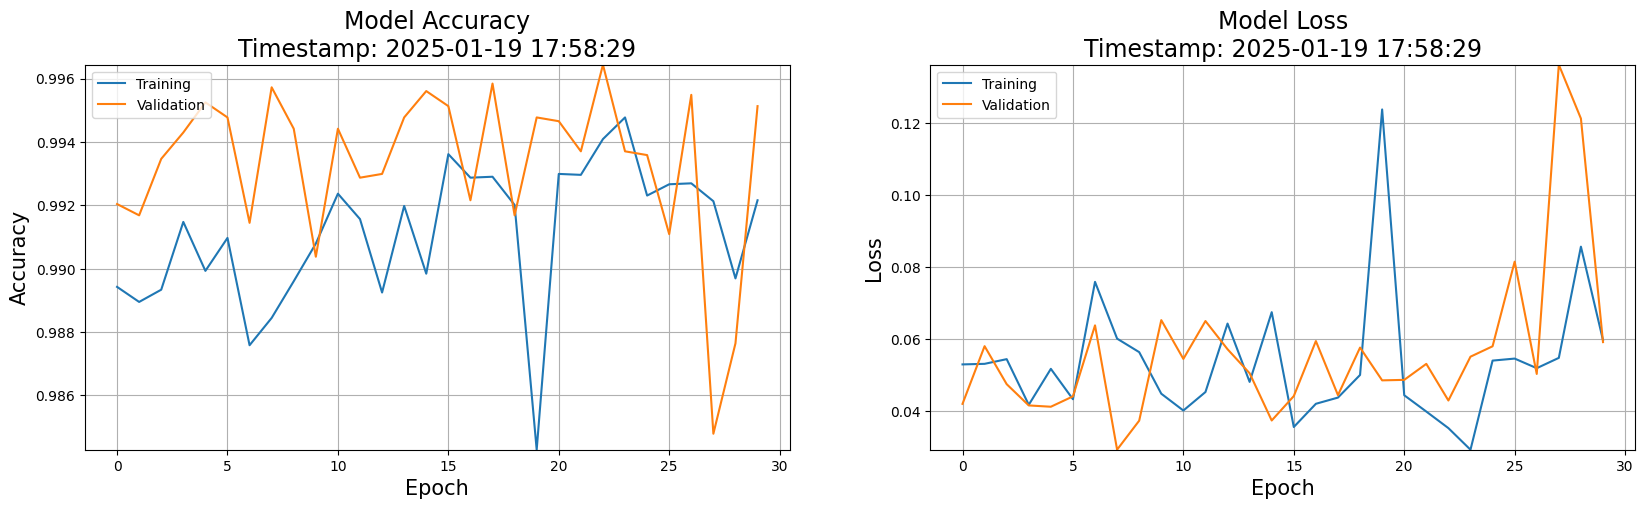

In [17]:
plot_performance(history=history1)

# 8. Loading Test Dataset and Evaluating the Model

In [18]:
# Importing the test dataset
y_test = pd.read_csv('./input/gtsrb-german-traffic-sign/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('./input/gtsrb-german-traffic-sign/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

In [19]:
# evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(labels, y_pred)

435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


0.9575447938403973

# 9. Saving the Model

In [20]:
# Saving the Model 
model.save('traffic_classifier_v3.keras')

# 10. Visualizing the Performance

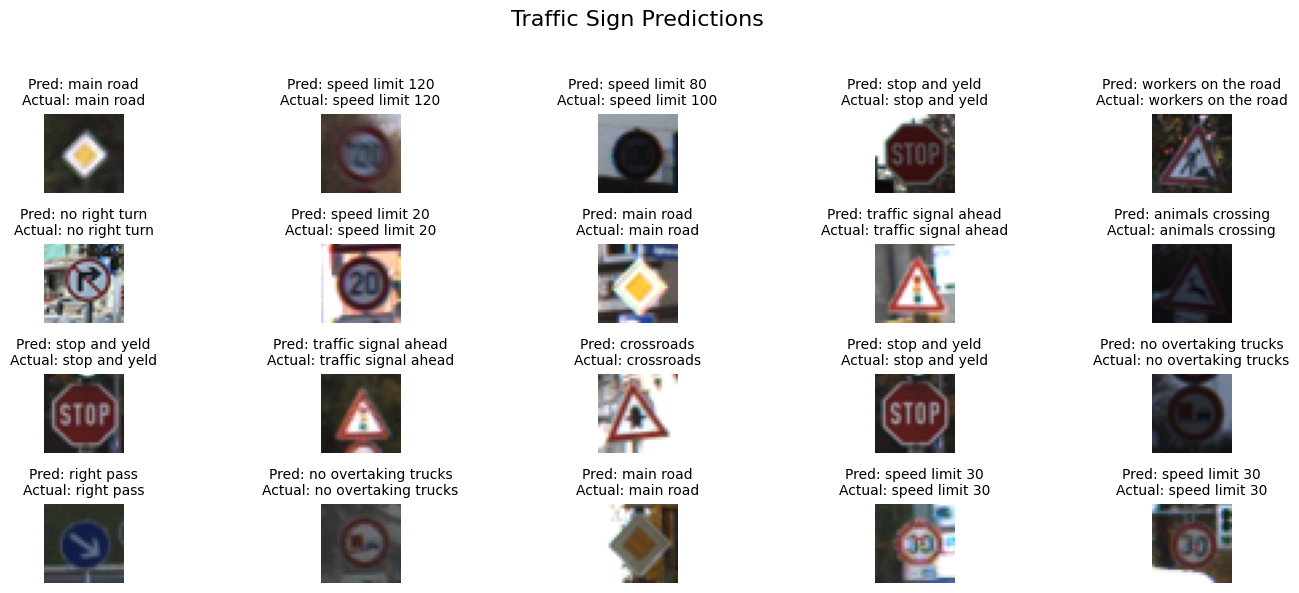

In [25]:
# Load the model
model = load_model('traffic_classifier_v3.keras', compile=False)

# Precompile the prediction logic using @tf.function
@tf.function
def predict_image(model, image):
    return model(image, training=False)

# Load the sign names
sign_names = pd.read_csv('./input/gtsrb-german-traffic-sign/Signs.csv')

# Prepare for visualization
fig, axes = plt.subplots(4, 5, figsize=(15, 6))  # 4 rows, 5 columns for 20 images
fig.suptitle('Traffic Sign Predictions', fontsize=16)

# Make and visualize 20 predictions
for i, ax in enumerate(axes.flat):
    # Select a random image index
    random_index = np.random.randint(len(X_test))
    
    # Get the image and actual label
    img_array = X_test[random_index]
    actual_class = labels[random_index]
    
    # Prepare the image for model prediction
    img_input = np.expand_dims(img_array, axis=0).astype(np.float32)
    
    # Predict the class of the image
    predicted_class = np.argmax(predict_image(model, img_input).numpy(), axis=-1)[0]
    
    # Get the corresponding sign names
    predicted_sign_name = sign_names[sign_names['Code'] == predicted_class].values[0][1]
    actual_sign_name = sign_names[sign_names['Code'] == actual_class].values[0][1]
    
    # Display the image and prediction
    ax.imshow(img_array)
    ax.set_title(f"Pred: {predicted_sign_name}\nActual: {actual_sign_name}", fontsize=10)
    ax.axis('off')  # Remove axes for cleaner visualization

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


In [26]:
meta = pd.read_csv('./input/gtsrb-german-traffic-sign/Meta.csv')
grouped = meta.groupby(['ShapeId', 'ColorId']).apply(lambda x: x['ClassId'].unique())
grouped

ShapeId  ColorId
0        0          [27, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...
         1                                           [55, 56, 57, 59]
         3                                                   [53, 54]
1        0                [0, 1, 10, 15, 16, 17, 2, 3, 4, 5, 7, 8, 9]
         1                           [33, 34, 35, 36, 37, 38, 39, 40]
         3                                            [32, 41, 42, 6]
2        2                                                       [12]
3        0                                                       [14]
4        0                                                       [13]
5        1                                                       [60]
dtype: object

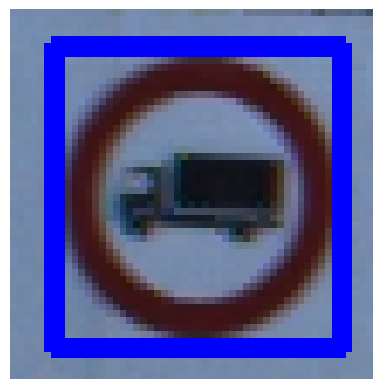

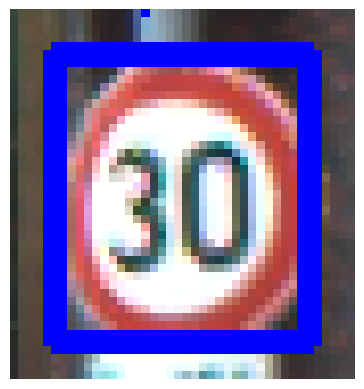

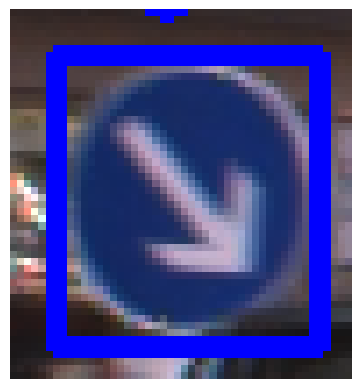

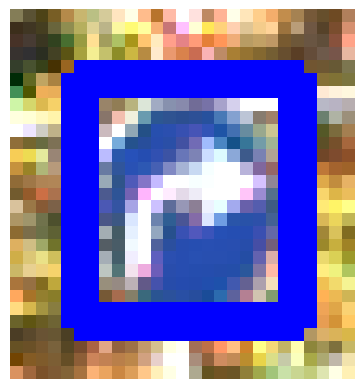

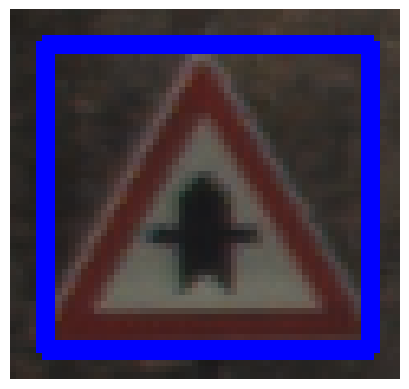

In [27]:
# Load necessary datasets
test_data = pd.read_csv('./input/gtsrb-german-traffic-sign/Test.csv')
sign_names = pd.read_csv('./input/gtsrb-german-traffic-sign/Signs.csv')

# Function to convert bounding box data into YOLO format (optional, not required for visualization)
def convert_to_yolo_format(row):
    x_center = (row['Roi.X1'] + row['Roi.X2']) / 2 / row['Width']
    y_center = (row['Roi.Y1'] + row['Roi.Y2']) / 2 / row['Height']
    box_width = (row['Roi.X2'] - row['Roi.X1']) / row['Width']
    box_height = (row['Roi.Y2'] - row['Roi.Y1']) / row['Height']
    return f"{row['ClassId']} {x_center} {y_center} {box_width} {box_height}"

# Add YOLO format as a new column (optional)
test_data['YOLO_Format'] = test_data.apply(convert_to_yolo_format, axis=1)

# Define a function to draw bounding boxes on images
def draw_bounding_box(img_path, box, label):
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found at path: {img_path}")
        return
    # Convert box coordinates to integer
    x1, y1, x2, y2 = map(int, box)
    # Draw rectangle
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    # Add label text
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Iterate through test data and display bounding boxes (run 5 times only)
for _, row in test_data.head(5).iterrows():
    # Extract bounding box coordinates and label
    box = [row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']]
    label = sign_names[sign_names['Code'] == row['ClassId']].iloc[0]['Sign']
    # Construct image path
    img_path = './input/gtsrb-german-traffic-sign/' + row['Path']
    # Draw bounding box
    draw_bounding_box(img_path, box, label)